In the previous step, we have determined the best approach to imputing missing features. In this stage, we focus on improving the quality of our DNN model, trained on labelled data, in isolation. In parallel we may seek to optimise other models, such as XGBoost, and later aggregate these models.

**Constants:**
* Feature selection, preprocessing of tabular data
* Missing feature imputation approach, as determined previously
* Using labelled data only
* Using DNN model only

**Varying:**
* Including or not including actigraph data
* PCA on included features
* Augmenting vs not augmenting data
* DNN model parameters and architecture
* Using sample weights based on number of features imputed
* Evaluation function: negative mean squared error or QWK on binned target
* Targeting PCIAT-PCIAT_Total or sii


In [1]:
import numpy as np
import pandas as pd

import os

import polars as pl
from glob import glob
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.svm import SVR

import lightgbm as lgb

from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import matplotlib.pyplot as plt

In [2]:
train_data=pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [3]:
INPUT_DIR = "/kaggle/input/child-mind-institute-problematic-internet-use/"

# Import aggregate fields from parquet files
# Modified code from rsakata: https://www.kaggle.com/code/rsakata/cmi-piu-16th-place-solution

files_train = glob(INPUT_DIR + "series_train.parquet/*")
#if IS_SUBMIT:
#    files += glob(INPUT_DIR + "series_test.parquet/*")

list_df_train = []
for file in tqdm(files_train):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df_train.append(df_series.to_pandas())

df_series = pd.concat(list_df_train)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg_train = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg_train.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg_train.columns]
df_agg_train

  0%|          | 0/996 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807
2,00f332d1,-3.071176,0.927238,3.249122,0.463244,1.138379,2.939823
3,01085eb3,-2.902040,0.791255,3.389762,0.315061,1.054698,2.185839
4,012cadd8,-2.806918,1.171675,3.337322,0.388409,0.823770,3.350365
...,...,...,...,...,...,...,...
964,fe9c71d8,-3.116904,0.961804,3.037607,0.943554,-0.394200,2.742634
965,fecc07d6,-3.969482,0.981531,1.332831,1.428363,-0.438018,1.795653
966,ff18b749,-2.820076,0.937540,3.258458,0.417267,1.236652,3.341580
967,ffcd4dbd,-3.271800,0.827489,3.183395,0.629553,0.521227,2.665325


In [4]:
train_data2 = train_data.merge(df_agg_train, how="left", on="id")
train_data2.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.0,Winter,0.0,1.0,-4.000377,NaN,1.989905,NaN,0.051475,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
files_test = glob(INPUT_DIR + "series_test.parquet/*")


list_df_test = []
for file in tqdm(files_test):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df_test.append(df_series.to_pandas())

df_series = pd.concat(list_df_test)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg_test = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg_test.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg_test.columns]
df_agg_test

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807


In [6]:
test_data2 = test_data.merge(df_agg_test, how="left", on="id")
test_data2.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,31.0,45.0,Winter,0.0,-4.000377,NaN,1.989905,NaN,0.051475,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
X_train = train_data2[['Basic_Demos-Age',
                      'Basic_Demos-Sex',
                      'CGAS-CGAS_Score',
                      'Physical-BMI',
                      'BIA-BIA_BMI',
                      'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP',
                      'Physical-HeartRate',
                      'Physical-Systolic_BP',
                      'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins',
                      'Fitness_Endurance-Time_Sec',
                      'FGC-FGC_CU_Zone',
                      'FGC-FGC_GSND_Zone',
                      'FGC-FGC_GSD_Zone',
                      'FGC-FGC_PU_Zone',
                      'FGC-FGC_SRL_Zone',
                      'FGC-FGC_SRR_Zone',
                      'FGC-FGC_TL_Zone',
                      'BIA-BIA_Activity_Level_num',
                      'BIA-BIA_BMC',
                      'BIA-BIA_BMR',
                      'BIA-BIA_DEE',
                      'BIA-BIA_ECW',
                      'BIA-BIA_FFM',
                      'BIA-BIA_FFMI',
                      'BIA-BIA_FMI',
                      'BIA-BIA_Fat',
                      'BIA-BIA_ICW',
                      'BIA-BIA_LDM',
                      'BIA-BIA_LST',
                      'BIA-BIA_SMM',
                      'BIA-BIA_TBW',
                      'PAQ_A-PAQ_A_Total',
                      'PAQ_C-PAQ_C_Total',
                      'SDS-SDS_Total_T',
                      'PreInt_EduHx-computerinternet_hoursday'
                      # ,
                      #'enmo_std_mean',
                      #'enmo_std_std',
                      #'anglez_std_mean',
                      #'anglez_std_std',
                      #'light_std_mean',
                      #'light_std_std',
                      ]]

y_train = train_data2['PCIAT-PCIAT_Total']

X_test = test_data2[['Basic_Demos-Age',
                      'Basic_Demos-Sex',
                      'CGAS-CGAS_Score',
                      'Physical-BMI',
                      'BIA-BIA_BMI',
                      'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP',
                      'Physical-HeartRate',
                      'Physical-Systolic_BP',
                      'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins',
                      'Fitness_Endurance-Time_Sec',
                      'FGC-FGC_CU_Zone',
                      'FGC-FGC_GSND_Zone',
                      'FGC-FGC_GSD_Zone',
                      'FGC-FGC_PU_Zone',
                      'FGC-FGC_SRL_Zone',
                      'FGC-FGC_SRR_Zone',
                      'FGC-FGC_TL_Zone',
                      'BIA-BIA_Activity_Level_num',
                      'BIA-BIA_BMC',
                      'BIA-BIA_BMR',
                      'BIA-BIA_DEE',
                      'BIA-BIA_ECW',
                      'BIA-BIA_FFM',
                      'BIA-BIA_FFMI',
                      'BIA-BIA_FMI',
                      'BIA-BIA_Fat',
                      'BIA-BIA_ICW',
                      'BIA-BIA_LDM',
                      'BIA-BIA_LST',
                      'BIA-BIA_SMM',
                      'BIA-BIA_TBW',
                      'PAQ_A-PAQ_A_Total',
                      'PAQ_C-PAQ_C_Total',
                      'SDS-SDS_Total_T',
                      'PreInt_EduHx-computerinternet_hoursday'
                      #,
                      #'enmo_std_mean',
                      #'enmo_std_std',
                      #'anglez_std_mean',
                      #'anglez_std_std',
                      #'light_std_mean',
                      #'light_std_std',
                   ]]

In [8]:
# Add calculated fields
X_train['Physical-BMI_Calc'] = X_train.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
X_train['Fitness_Endurance-Time_Sec_Calc'] = X_train.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
X_train['PAQ_Total'] = X_train.apply(lambda row: row['PAQ_A-PAQ_A_Total'] if row['PAQ_A-PAQ_A_Total']==row['PAQ_A-PAQ_A_Total'] else row['PAQ_C-PAQ_C_Total'],axis=1)


# Drop fields no longer needed
X_train = X_train.drop(columns=['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total',
                     'Physical-BMI','BIA-BIA_BMI',
                     'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec'])

# Remove outliers - may give warnings due to NaN value comparison
X_train.loc[X_train['CGAS-CGAS_Score']>=100.0,'CGAS-CGAS_Score'] = np.nan
X_train.loc[X_train['Physical-Systolic_BP']>=180.0,'Physical-Systolic_BP'] = np.nan
X_train.loc[X_train['Physical-Diastolic_BP']>=120.0,'Physical-Diastolic_BP'] = np.nan
X_train.loc[X_train['BIA-BIA_DEE']>=6000.0,'BIA-BIA_DEE'] = np.nan
X_train.loc[(X_train['BIA-BIA_BMC']<=0.0) | (X_train['BIA-BIA_BMC']>=16.0),'BIA-BIA_BMC'] = np.nan
X_train.loc[(X_train['BIA-BIA_BMR']<=0.0) | (X_train['BIA-BIA_BMR']>=2400.0),'BIA-BIA_BMR'] = np.nan
X_train.loc[(X_train['BIA-BIA_ECW']<=0.0) | (X_train['BIA-BIA_ECW']>=60.0),'BIA-BIA_ECW'] = np.nan
X_train.loc[(X_train['BIA-BIA_FFM']<=0.0) | (X_train['BIA-BIA_FFM']>=200.0),'BIA-BIA_FFM'] = np.nan
X_train.loc[(X_train['BIA-BIA_FFMI']<=0.0) | (X_train['BIA-BIA_FFMI']>=25.0),'BIA-BIA_FFMI'] = np.nan
X_train.loc[(X_train['BIA-BIA_FMI']<=0.0) | (X_train['BIA-BIA_FMI']>=25.0),'BIA-BIA_FMI'] = np.nan
X_train.loc[(X_train['BIA-BIA_Fat']<=8.0) | (X_train['BIA-BIA_Fat']>=60.0),'BIA-BIA_Fat'] = np.nan
X_train.loc[(X_train['BIA-BIA_ICW']<=0.0) | (X_train['BIA-BIA_ICW']>=80.0),'BIA-BIA_ICW'] = np.nan
X_train.loc[(X_train['BIA-BIA_LDM']<=0.0) | (X_train['BIA-BIA_LDM']>=60.0),'BIA-BIA_LDM'] = np.nan
X_train.loc[(X_train['BIA-BIA_LST']<=0.0) | (X_train['BIA-BIA_LST']>=150.0),'BIA-BIA_LST'] = np.nan
X_train.loc[(X_train['BIA-BIA_SMM']<=0.0) | (X_train['BIA-BIA_SMM']>=100.0),'BIA-BIA_SMM'] = np.nan
X_train.loc[(X_train['BIA-BIA_TBW']<=0.0) | (X_train['BIA-BIA_TBW']>=150.0),'BIA-BIA_TBW'] = np.nan

<ipython-input-8-7507d9027830>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Physical-BMI_Calc'] = X_train.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
<ipython-input-8-7507d9027830>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Fitness_Endurance-Time_Sec_Calc'] = X_train.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
<ipython-input-8-7507d9027830>:4: SettingWi

In [9]:
# Noting number of features we are imputing
# These different weighting strategies will be tried when fitting our model

# Approach 1 - proportion of total features imputed
features_missing = X_train.isnull().sum(axis=1)/X_train.shape[1]
weights = 1 - features_missing  # Weighting based on missingness score

# Approach 2 - geometric reduction in weight by features imputed
features_missing2 = X_train.isnull().sum(axis=1)
weights2 = 1 * ((0.95)**features_missing2)

# Approach 3 - exponential decay. Intention is to heavily penalise rows with most features missing
weights3 = np.exp((-2)*features_missing)
weights3.head(10)

0    0.555306
1    0.702619
2    0.413808
3    0.838223
4    0.161455
5    0.790338
6    0.662480
7    0.790338
8    0.161455
9    0.152231
dtype: float64

In [10]:
features_missing_labelled = X_train.loc[y_train.notna()].isnull().sum(axis=1)/X_train.shape[1]
weights_labelled = 1 - features_missing_labelled
weights_labelled.shape

features_missing_labelled2 = X_train.loc[y_train.notna()].isnull().sum(axis=1)
weights_labelled2 = 1 * ((0.95)**features_missing_labelled2)

weights_labelled3 = np.exp((-2)*features_missing_labelled)

In [11]:
#MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_fimpute = pd.DataFrame(iter_imputer.fit_transform(X_train), columns = X_train.columns)
X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,10.433586,0.372727,64.818333,26.974426,69.403169,81.519388,116.805724,4.974030,0.480343,1.849340,...,31.365620,18.066786,63.749033,31.477562,50.138601,57.881433,1.073783,19.374281,468.721596,2.537644
std,3.574648,0.483591,9.805847,4.770198,11.011761,12.021297,14.228392,0.935016,0.389401,0.346190,...,7.099089,5.021442,18.068723,10.250418,13.839926,10.737030,1.022870,4.520383,89.856124,0.653839
min,5.000000,0.000000,-23.164848,4.967968,0.000000,27.000000,0.000000,0.000000,-0.172314,-1.772461,...,14.489000,4.635810,23.620100,4.655730,20.589200,38.000000,-0.278039,0.000000,5.000000,0.580000
25%,8.000000,0.000000,60.000000,24.000000,64.000000,74.477905,109.000000,4.865373,0.000000,1.766934,...,28.665877,16.394825,56.747700,27.190300,44.819225,51.000000,0.000000,16.485531,450.588533,2.150000
50%,10.000000,0.000000,64.765647,26.137767,69.000000,81.485263,115.604541,4.973003,0.485209,1.872826,...,31.347850,18.058831,63.734357,30.792761,50.135566,57.770114,1.000000,18.589876,469.207062,2.567600
75%,13.000000,1.000000,70.000000,29.035486,73.000000,87.000000,122.000000,5.081351,1.000000,2.000000,...,32.689980,18.232694,63.917531,33.007960,50.147145,60.000000,2.000000,21.015855,487.416029,2.886524
max,22.000000,1.000000,95.000000,56.944995,119.000000,138.000000,179.000000,28.000000,1.129295,3.000000,...,86.587576,52.527500,188.145195,111.835760,146.075000,100.000000,3.019947,59.132048,2154.275208,4.790000


In [12]:
# Clip imputed values to original max and min
for column in X_train_fimpute.columns:
    max_val = np.max(X_train[column])
    min_val = np.min(X_train[column])
    X_train_fimpute.loc[X_train_fimpute[column]>max_val,column] = max_val
    X_train_fimpute.loc[X_train_fimpute[column]<min_val, column] = min_val

X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,10.433586,0.372727,64.830496,26.998653,69.403169,81.519388,116.805724,4.974030,0.480419,1.850041,...,31.363446,18.066786,63.672368,31.469455,50.138601,57.881433,1.073848,19.374281,468.480617,2.537644
std,3.574648,0.483591,9.726236,4.692416,11.011761,12.021297,14.228392,0.935016,0.389164,0.341634,...,7.083396,5.021442,17.644465,10.193244,13.839926,10.737030,1.022777,4.520383,86.553527,0.653839
min,5.000000,0.000000,25.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,1.000000,...,14.489000,4.635810,23.620100,4.655730,20.589200,38.000000,0.000000,0.000000,5.000000,0.580000
25%,8.000000,0.000000,60.000000,24.000000,64.000000,74.477905,109.000000,4.865373,0.000000,1.766934,...,28.665877,16.394825,56.747700,27.190300,44.819225,51.000000,0.000000,16.485531,450.588533,2.150000
50%,10.000000,0.000000,64.765647,26.137767,69.000000,81.485263,115.604541,4.973003,0.485209,1.872826,...,31.347850,18.058831,63.734357,30.792761,50.135566,57.770114,1.000000,18.589876,469.207062,2.567600
75%,13.000000,1.000000,70.000000,29.035486,73.000000,87.000000,122.000000,5.081351,1.000000,2.000000,...,32.689980,18.232694,63.917531,33.007960,50.147145,60.000000,2.000000,21.015855,487.416029,2.886524
max,22.000000,1.000000,95.000000,50.000000,119.000000,138.000000,179.000000,28.000000,1.000000,3.000000,...,79.473800,52.527500,149.830000,97.923100,146.075000,100.000000,3.000000,59.132048,1200.000000,4.790000


In [13]:
scaler = StandardScaler()                  

X_train_fimpute[X_train_fimpute.columns] = scaler.fit_transform(X_train_fimpute[X_train_fimpute.columns])
X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,...,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03
mean,-1.928872e-16,-5.831474e-17,8.343494e-16,5.921189e-17,2.866394e-16,4.893953e-16,-3.545985e-16,6.948426e-16,-1.282924e-16,1.058637e-16,...,-3.184882e-16,-1.004808e-16,1.040694e-16,-4.135861e-16,1.964758e-16,-1.821214e-16,-5.741759e-17,9.796877e-16,4.831152e-16,-1.578984e-16
std,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,...,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00
min,-1.520226e+00,-7.708456e-01,-4.095678e+00,-1.917944e+00,-6.303437e+00,-4.535806e+00,-8.210378e+00,-5.320400e+00,-1.234646e+00,-2.488480e+00,...,-2.382555e+00,-2.675063e+00,-2.270249e+00,-2.630871e+00,-2.135353e+00,-1.851904e+00,-1.050066e+00,-4.286523e+00,-5.355520e+00,-2.994455e+00
25%,-6.808763e-01,-7.708456e-01,-4.967087e-01,-6.391231e-01,-4.907346e-01,-5.858247e-01,-5.486713e-01,-1.162227e-01,-1.234646e+00,-2.432958e-01,...,-3.808780e-01,-3.330064e-01,-3.925051e-01,-4.198561e-01,-3.843986e-01,-6.409875e-01,-1.050066e+00,-6.391307e-01,-2.067431e-01,-5.929487e-01
50%,-1.213100e-01,-7.708456e-01,-6.668295e-03,-1.834866e-01,-3.661725e-02,-2.839099e-03,-8.443218e-02,-1.098129e-03,1.230976e-02,6.670247e-02,...,-2.202046e-03,-1.584385e-03,3.513687e-03,-6.639494e-02,-2.193295e-04,-1.036914e-02,-7.221268e-02,-1.735482e-01,8.394070e-03,4.582149e-02
75%,7.180394e-01,1.297277e+00,5.315681e-01,4.341239e-01,3.266766e-01,4.559661e-01,3.651103e-01,1.147947e-01,1.335289e+00,4.390017e-01,...,1.872974e-01,3.304415e-02,1.389639e-02,1.509529e-01,6.173593e-04,1.973390e-01,9.056408e-01,3.631950e-01,2.187987e-01,5.336544e-01
max,3.236088e+00,1.297277e+00,3.102260e+00,4.902432e+00,4.504556e+00,4.698973e+00,4.371691e+00,2.462940e+01,1.335289e+00,3.366483e+00,...,6.792848e+00,6.863580e+00,4.883600e+00,6.520205e+00,6.932733e+00,3.923235e+00,1.883494e+00,8.796331e+00,8.452709e+00,3.445252e+00


In [14]:
# Repeat the above for X_test

# Add calculated fields
X_test['Physical-BMI_Calc'] = X_test.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
X_test['Fitness_Endurance-Time_Sec_Calc'] = X_test.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
X_test['PAQ_Total'] = X_test.apply(lambda row: row['PAQ_A-PAQ_A_Total'] if row['PAQ_A-PAQ_A_Total']==row['PAQ_A-PAQ_A_Total'] else row['PAQ_C-PAQ_C_Total'],axis=1)

# Drop fields no longer needed
X_test = X_test.drop(columns=['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total',
                     'Physical-BMI','BIA-BIA_BMI',
                     'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec'])

# Remove outliers
X_test.loc[X_test['CGAS-CGAS_Score']>=100.0,'CGAS-CGAS_Score'] = np.nan
X_test.loc[X_test['Physical-Systolic_BP']>=180.0,'Physical-Systolic_BP'] = np.nan
X_test.loc[X_test['Physical-Diastolic_BP']>=120.0,'Physical-Diastolic_BP'] = np.nan
X_test.loc[X_test['BIA-BIA_DEE']>=6000.0,'BIA-BIA_DEE'] = np.nan
X_test.loc[(X_test['BIA-BIA_BMC']<=0.0) | (X_test['BIA-BIA_BMC']>=16.0),'BIA-BIA_BMC'] = np.nan
X_test.loc[(X_test['BIA-BIA_BMR']<=0.0) | (X_test['BIA-BIA_BMR']>=2400.0),'BIA-BIA_BMR'] = np.nan
X_test.loc[(X_test['BIA-BIA_ECW']<=0.0) | (X_test['BIA-BIA_ECW']>=60.0),'BIA-BIA_ECW'] = np.nan
X_test.loc[(X_test['BIA-BIA_FFM']<=0.0) | (X_test['BIA-BIA_FFM']>=200.0),'BIA-BIA_FFM'] = np.nan
X_test.loc[(X_test['BIA-BIA_FFMI']<=0.0) | (X_test['BIA-BIA_FFMI']>=25.0),'BIA-BIA_FFMI'] = np.nan
X_test.loc[(X_test['BIA-BIA_FMI']<=0.0) | (X_test['BIA-BIA_FMI']>=25.0),'BIA-BIA_FMI'] = np.nan
X_test.loc[(X_test['BIA-BIA_Fat']<=8.0) | (X_test['BIA-BIA_Fat']>=60.0),'BIA-BIA_Fat'] = np.nan
X_test.loc[(X_test['BIA-BIA_ICW']<=0.0) | (X_test['BIA-BIA_ICW']>=80.0),'BIA-BIA_ICW'] = np.nan
X_test.loc[(X_test['BIA-BIA_LDM']<=0.0) | (X_test['BIA-BIA_LDM']>=60.0),'BIA-BIA_LDM'] = np.nan
X_test.loc[(X_test['BIA-BIA_LST']<=0.0) | (X_test['BIA-BIA_LST']>=150.0),'BIA-BIA_LST'] = np.nan
X_test.loc[(X_test['BIA-BIA_SMM']<=0.0) | (X_test['BIA-BIA_SMM']>=100.0),'BIA-BIA_SMM'] = np.nan
X_test.loc[(X_test['BIA-BIA_TBW']<=0.0) | (X_test['BIA-BIA_TBW']>=150.0),'BIA-BIA_TBW'] = np.nan

<ipython-input-14-ee14b5292b05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Physical-BMI_Calc'] = X_test.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
<ipython-input-14-ee14b5292b05>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Fitness_Endurance-Time_Sec_Calc'] = X_test.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
<ipython-input-14-ee14b5292b05>:6: SettingWit

In [15]:
# Imputation
X_test_fimpute = pd.DataFrame(iter_imputer.transform(X_test), columns = X_test.columns)

# Clipping
for column in X_test_fimpute.columns:
    max_val = np.max(X_train[column])
    min_val = np.min(X_train[column])
    X_test_fimpute.loc[X_test_fimpute[column]>max_val,column] = max_val
    X_test_fimpute.loc[X_test_fimpute[column]<min_val, column] = min_val

# Scaling
X_test_fimpute[X_test_fimpute.columns] = scaler.transform(X_test_fimpute[X_test_fimpute.columns])

X_test_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.088527,0.056403,-0.045878,0.062078,-0.054532,-0.024661,0.096746,-0.099940,-0.092855,-0.200220,...,-0.201746,-0.212473,-0.149911,-0.186412,-0.143597,-0.248715,0.397885,0.159731,-0.138408,-0.321770
std,1.042416,1.039489,0.801382,0.834814,0.728397,0.630397,1.095310,0.609633,1.064675,0.889571,...,0.502229,0.550313,0.534173,0.543306,0.553989,0.532311,1.029493,0.885501,0.532544,1.215554
min,-1.520226,-0.770846,-1.524985,-1.917944,-1.126499,-0.958369,-1.532744,-1.982619,-1.234646,-2.488480,...,-1.458277,-1.826683,-1.403148,-1.575630,-1.668095,-1.665609,-1.050066,-1.181175,-1.577034,-2.290829
25%,-0.401093,-0.770846,-0.398350,-0.639123,-0.626970,-0.479991,-0.323267,-0.117459,-1.234646,-0.271331,...,-0.353243,-0.152373,-0.072266,-0.321185,-0.053025,-0.384832,-0.316676,-0.484882,-0.194965,-0.793832
50%,-0.121310,-0.770846,0.053470,0.186887,0.013374,-0.096654,0.013656,-0.010525,-0.226210,-0.084494,...,-0.172488,-0.012274,0.001130,-0.057763,-0.000024,-0.036684,0.905641,0.059206,-0.060168,-0.247980
75%,0.508202,1.297277,0.442934,0.601291,0.157655,0.349697,0.359988,0.109218,1.335289,0.310673,...,0.143634,0.007697,0.007959,0.164499,0.000693,0.043558,0.934083,0.438107,0.054260,0.197347
max,2.396738,1.297277,1.559845,1.827302,2.099974,1.287928,3.247037,1.097415,1.335289,1.002942,...,0.662725,0.564693,0.908379,0.466421,0.938555,0.569929,1.883494,2.371861,1.253942,2.405110


# Use labelled data only

In [16]:
X_train_labelled = X_train_fimpute.loc[y_train.notna()]
y_train_labelled = y_train[y_train.notna()]
print("Size of labelled train data set is: ", (X_train_labelled.shape, y_train_labelled.shape))

Size of labelled train data set is:  ((2736, 34), (2736,))


In [17]:
# Since we are not using the unlabelled data in this notebook, we can drop the indices
# This will help us prevent any accidents when doing cross-validation when we split by index, don't have to think about loc vs iloc etc.

X_train_labelled = X_train_labelled.reset_index(drop=True)
y_train_labelled = y_train_labelled.reset_index(drop=True)

In [18]:
weights_labelled = weights_labelled.reset_index(drop=True)
weights_labelled2 = weights_labelled2.reset_index(drop=True)
weights_labelled3 = weights_labelled3.reset_index(drop=True)

# Experimentation - optimising model

We are trying to find the best combination of:
* Parquet data inclusion: No, Yes
* PCA: all, 95%, 90%
* Augment data: None, 1x noisy, 2x noisy, 1x noisier, 2x noisier
* Loss/Evaluation function: NMSE or QWK
* Model parameters:
    * Number of hidden layers: 1, 2, 3, 4, 5
    * Number of neurons in each layer
    * Regularisation parameters: None, L1, L2, Elastic Net
    * Dropout layers: None, 0.1, 0.2, 0.3
    * Activation function: selu, relu
    * Initialiser: He, Glorot
    * Batch normalisation: No, Yes
    * Learning rate (scheduler): 0.002, 0.005, 0.008, step decay, exponential decay
* Sample weight when fitting: None, Linear, Exponential

**Approach**:
1. Begin with basic parameters:
    * No Parquet
    * No PCA
    * No Data Augmentation
    * NMSE Loss
    * No Sample Weight
    * Basic model:
        * 1 hidden layer
        * 50 neurons
        * No L1 or L2 regularisation
        * Dropout 0.2 (I think it is generally a good idea to include dropout, especially as our model inevitably becomes more complex)
        * selu activation (probably won't experiment with this too much)
        * He initialisation (probably won't experiment much)
        * No batch normalisation
        * Learning rate constant 0.005
2. Evaluate model - underfitting, overfitting?
3. Make modifications - increase complexity if underfitting, add regularization if overfitting
4. Iteratively improve - ideally we will increase the model complexity until it starts to overfit, then test regularisation. Will probably look to improve the DNN architecture for a while before starting to change anything else

Sounds straightforward in theory, but we know better.

# Models

In [19]:
from sklearn.metrics import cohen_kappa_score

In [43]:
def bin_target(y_val, max_val=100, num_classes=11):
    #return y_val//(num_classes-1) #integer division for ordinal classes
    return y_val//(max_val//(num_classes-1)) 
    #e.g., 100 split into 11 classes: 0-9, 10-19, ..., 90-99, 100
    # 100 split into 6 classes: 0-19, 20-39, ..., 80-99, 100
    # With 0-100 values doing integer division we have this extra 100 term in its own class - there's probably a better way of splitting

In [20]:
'''
# QWK Calculation
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Discretize continuous predictions if needed (e.g., rounding)
    y_pred = np.round(y_pred)
    
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Convert QWK to a TensorFlow-friendly metric
def qwk_metric(y_true, y_pred):
    qwk_value = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)
    return qwk_value

# Custom loss that combines MSE and QWK
def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error
    qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK
    qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)
    # Add a weighting factor
    return mse_loss - 0.5 * qwk_loss
'''

In [21]:
#np.linspace(0,100,5)

In [22]:
#a = pd.DataFrame([13,27,64,1,6,97,100])
#print(bin_target(a,100,11))
#print(bin_target(a,100,6))

In [23]:
#a = tf.constant([13,27,64,1,6,97,100]) 
#b = bin_target(a.numpy())
#print(b)

In [21]:
# Some reference to https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa

from sklearn.metrics import confusion_matrix

def qwk(y_true, y_pred):
    num_classes=11 # Ranging from 0 to 10 (from (0 to 100) // 10). Slightly sketch since 10 is 1/10th as likely as any other class. The hope is that there aren't enough 100s to matter
    #return cohen_kappa_score(y_true.numpy(), y_pred.numpy(), weights='quadratic') 
    # didn't manage to get the above working, ended up writing the function manually
    max_val=100
    y_true_bin = bin_target(y_true.numpy(),max_val,num_classes)
    y_pred_bin = bin_target(y_pred.numpy(),max_val,num_classes) # Not working because SymbolicTensorflow doesn't have .numpy() apparently - solved here: https://github.com/tensorflow/tensorflow/issues/27519 comment by kenyukobayashi
    
    #y_true_bin = bin_target(tf.make_ndarray(y_true),num_classes)
    #y_pred_bin = bin_target(tf.make_ndarray(y_pred),num_classes)

    # Confusion matrix O
    O = confusion_matrix(y_true_bin, y_pred_bin, labels=np.arange(num_classes))
    O = O/O.sum()

    # Calculate the weight matrix W
    W = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = (i - j) ** 2 / (num_classes - 1) ** 2

    E = np.outer(np.sum(O, axis=1), np.sum(O, axis=0))

    num = np.sum(W * O)
    denom = np.sum(W * E)
    return (1 - (num/denom)) 
    

In [22]:
a = tf.constant([9,54,72])
b = tf.constant([6,61,75])

qwk(a,b)

NameError: name 'bin_target' is not defined

In [23]:
k = 3  # Number of folds for cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Set shuffle=True to randomize data splits

# V1: Basic one layer

In [27]:
def create_model_v1():
    model = keras.models.Sequential([
        keras.layers.Dense(50, input_shape=(X_train_labelled.shape[1],), activation="selu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(1, activation="linear")
    ])

    model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mae','mse',qwk],run_eagerly=True) #run_eagerly=True is necessary in order for the tf.numpy() function in qwk to work
    return model

In [49]:
# Prepare to store results
validation_losses = []
models = []

# Loop over each fold
#for train_index, val_index in kf.split(X_train_labelled):
    # Split the data into training and validation sets for the current fold
#    X_train_t, X_train_v = X_train_labelled.loc[train_index], X_train_labelled.loc[val_index]
#    y_train_t, y_train_v = y_train_labelled.loc[train_index], y_train_labelled.loc[val_index]

    # Build a new model for each fold
#    model = create_model_v1()
    
    # Define early stopping to avoid overfitting
#    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Train the model on the training set and evaluate on the validation set
#    history = model.fit(
#        X_train_t, y_train_t,
#        validation_data=(X_train_v, y_train_v),
#        epochs=200,
#        batch_size=64,
#        callbacks=[early_stopping],
#        verbose=2
#    )
    
    # Evaluate the model on the validation set
#    val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
#    validation_losses.append(val_loss)
#    models.append(model)

# Calculate the average validation loss across all folds
#avg_val_loss = np.mean(validation_losses)
#print(f"Average Validation Loss: {avg_val_loss}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
29/29 - 1s - 51ms/step - loss: 1093.4996 - mae: 27.3390 - mse: 1093.4996 - qwk: 0.0158 - val_loss: 889.1447 - val_mae: 24.1379 - val_mse: 889.1447 - val_qwk: 0.0812
Epoch 2/200
29/29 - 1s - 47ms/step - loss: 817.4344 - mae: 23.1854 - mse: 817.4344 - qwk: 0.0976 - val_loss: 611.1226 - val_mae: 19.4533 - val_mse: 611.1226 - val_qwk: 0.1787
Epoch 3/200
29/29 - 1s - 49ms/step - loss: 576.6937 - mae: 19.0706 - mse: 576.6937 - qwk: 0.1683 - val_loss: 460.4323 - val_mae: 16.9806 - val_mse: 460.4323 - val_qwk: 0.2751
Epoch 4/200
29/29 - 1s - 48ms/step - loss: 460.0558 - mae: 17.0183 - mse: 460.0558 - qwk: 0.2430 - val_loss: 388.8248 - val_mae: 15.6383 - val_mse: 388.8248 - val_qwk: 0.3257
Epoch 5/200
29/29 - 1s - 48ms/step - loss: 377.0742 - mae: 15.5223 - mse: 377.0742 - qwk: 0.3213 - val_loss: 343.5949 - val_mae: 14.7882 - val_mse: 343.5949 - val_qwk: 0.3775
Epoch 6/200
29/29 - 1s - 47ms/step - loss: 337.9909 - mae: 14.7248 - mse: 337.9909 - qwk: 0.3899 - val_loss: 320.5114 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 - 1s - 50ms/step - loss: 1100.2269 - mae: 27.0517 - mse: 1100.2269 - qwk: 0.0175 - val_loss: 968.7047 - val_mae: 25.6485 - val_mse: 968.7047 - val_qwk: 0.0276
Epoch 2/200
29/29 - 1s - 49ms/step - loss: 839.3163 - mae: 23.2492 - mse: 839.3163 - qwk: 0.1040 - val_loss: 687.4525 - val_mae: 21.0107 - val_mse: 687.4525 - val_qwk: 0.1095
Epoch 3/200
29/29 - 1s - 48ms/step - loss: 597.5433 - mae: 19.4010 - mse: 597.5433 - qwk: 0.1837 - val_loss: 507.9373 - val_mae: 17.9267 - val_mse: 507.9373 - val_qwk: 0.1738
Epoch 4/200
29/29 - 1s - 47ms/step - loss: 486.8837 - mae: 17.4935 - mse: 486.8837 - qwk: 0.2515 - val_loss: 411.6736 - val_mae: 16.1071 - val_mse: 411.6736 - val_qwk: 0.2652
Epoch 5/200
29/29 - 1s - 49ms/step - loss: 405.4732 - mae: 15.8904 - mse: 405.4732 - qwk: 0.3352 - val_loss: 351.7168 - val_mae: 14.8674 - val_mse: 351.7168 - val_qwk: 0.3541
Epoch 6/200
29/29 - 1s - 48ms/step - loss: 360.5857 - mae: 15.1124 - mse: 360.5857 - qwk: 0.3730 - val_loss: 319.9222 - val_mae: 14.211

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 - 2s - 53ms/step - loss: 1066.0626 - mae: 26.2789 - mse: 1066.0626 - qwk: 0.0093 - val_loss: 1006.8986 - val_mae: 25.7076 - val_mse: 1006.8986 - val_qwk: 0.0258
Epoch 2/200
29/29 - 1s - 49ms/step - loss: 793.1336 - mae: 22.4547 - mse: 793.1336 - qwk: 0.0769 - val_loss: 709.0662 - val_mae: 21.2366 - val_mse: 709.0662 - val_qwk: 0.1300
Epoch 3/200
29/29 - 1s - 50ms/step - loss: 564.6698 - mae: 18.8144 - mse: 564.6698 - qwk: 0.1883 - val_loss: 543.9591 - val_mae: 18.7049 - val_mse: 543.9591 - val_qwk: 0.1778
Epoch 4/200
29/29 - 1s - 49ms/step - loss: 454.3202 - mae: 16.8684 - mse: 454.3202 - qwk: 0.2715 - val_loss: 441.3652 - val_mae: 16.8963 - val_mse: 441.3652 - val_qwk: 0.2393
Epoch 5/200
29/29 - 1s - 51ms/step - loss: 370.1662 - mae: 15.2804 - mse: 370.1662 - qwk: 0.3519 - val_loss: 374.6832 - val_mae: 15.5310 - val_mse: 374.6832 - val_qwk: 0.3317
Epoch 6/200
29/29 - 1s - 49ms/step - loss: 338.9432 - mae: 14.7202 - mse: 338.9432 - qwk: 0.3785 - val_loss: 345.7259 - val_mae: 14.8

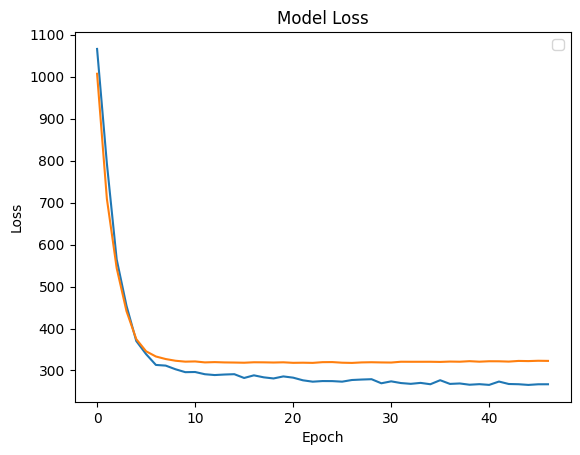

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 329.2241 - mae: 14.5348 - mse: 329.2241 - qwk: 0.4041
Validation loss: 318.0399, Validation MAE: 14.2896


In [50]:
# Graph most recent model history
'''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v)
print(f"Validation loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
'''

In [49]:
'''
plt.plot(history.history['qwk'])
plt.plot(history.history['val_qwk'])
plt.title('Model QWK')
plt.xlabel('Epoch')
plt.ylabel('QWK')
plt.legend(['qwk','val_qwk'])
plt.show()

val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v)
print(f"Validation QWK: {val_qwk:.4f}")
'''

'\nplt.plot(history.history[\'qwk\'])\nplt.plot(history.history[\'val_qwk\'])\nplt.title(\'Model QWK\')\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'QWK\')\nplt.legend([\'qwk\',\'val_qwk\'])\nplt.show()\n\nval_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v)\nprint(f"Validation QWK: {val_qwk:.4f}")\n'

Model not really improving after a time. Probably not complex enough, as expected.

**Score: 0.378, 0.370**

In [30]:
def neg_qwk(y_true, y_pred):
    return (-qwk(y_true,y_pred))
# Was trying to build a loss function, but wasn't really working as it seems it isn't differentiable
# Will look to build a different loss function with more in common with qwk than mse

# V2: Layered model

In [36]:
# Increase neurons and add another hidden layer
def create_model_v2():
    #model = keras.models.Sequential([
    #    keras.layers.Dense(128, input_shape=(X_train_labelled.shape[1],), activation="selu", kernel_initializer="he_normal"),
    #    keras.layers.Dropout(rate=0.2),
    #    keras.layers.Dense(64, activation="selu", kernel_initializer="he_normal"),
    #    keras.layers.Dropout(rate=0.2),
    #    keras.layers.Dense(32, activation="selu", kernel_initializer="he_normal"),
    #    keras.layers.Dropout(rate=0.2),
    #    keras.layers.Dense(1, activation="linear")
    #])

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(128, input_shape=(X_train_labelled.shape[1],), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(keras.layers.Activation('selu'))
    model.add(Dropout(0.2))
    model.add(keras.layers.Dense(64, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(keras.layers.Activation('selu'))
    model.add(Dropout(0.2))
    model.add(keras.layers.Dense(32, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(keras.layers.Activation('selu'))
    model.add(Dropout(0.2))
    model.add(keras.layers.Dense(32, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(keras.layers.Activation('selu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer=Adam(learning_rate=0.002), loss='mean_squared_error', metrics=['mae','mse',qwk],run_eagerly=True) #run_eagerly=True is necessary in order for the tf.numpy() function in qwk to work
    #model.compile(optimizer=Adam(learning_rate=0.005), loss=neg_qwk, metrics=[qwk],run_eagerly=True) #run_eagerly=True is necessary in order for the tf.numpy() function in qwk to work
    return model

In [37]:
'''
# Prepare to store results
validation_qwk = []
validation_losses = []
models = []

# Loop over each fold
for train_index, val_index in kf.split(X_train_labelled):
    # Split the data into training and validation sets for the current fold
    X_train_t, X_train_v = X_train_labelled.loc[train_index], X_train_labelled.loc[val_index]
    y_train_t, y_train_v = y_train_labelled.loc[train_index], y_train_labelled.loc[val_index]

    # Build a new model for each fold
    model = create_model_v2()
    
    # Define early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model on the training set and evaluate on the validation set
    history = model.fit(
        X_train_t, y_train_t,
        validation_data=(X_train_v, y_train_v),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=2
    )
    
    # Evaluate the model on the validation set
    val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    #val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    validation_qwk.append(val_qwk)
    validation_losses.append(val_loss)
    models.append(model)

# Calculate the average validation loss across all folds
avg_val_qwk = np.mean(validation_qwk)
avg_val_loss = np.mean(validation_losses)
print(f"Average Validation QWK: {avg_val_qwk}, Average Validation Loss: {avg_val_loss}")
'''

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
29/29 - 5s - 163ms/step - loss: 1154.2693 - mae: 28.3949 - mse: 1153.0018 - qwk: 0.0034 - val_loss: 1349.8922 - val_mae: 32.0319 - val_mse: 1348.6193 - val_qwk: 0.0841
Epoch 2/100
29/29 - 5s - 156ms/step - loss: 1066.2209 - mae: 27.8121 - mse: 1064.9446 - qwk: 0.0282 - val_loss: 1153.4597 - val_mae: 29.4269 - val_mse: 1152.1808 - val_qwk: 0.0938
Epoch 3/100
29/29 - 5s - 157ms/step - loss: 1000.6998 - mae: 26.9617 - mse: 999.4197 - qwk: 0.0486 - val_loss: 1029.4392 - val_mae: 27.4757 - val_mse: 1028.1587 - val_qwk: 0.1262
Epoch 4/100
29/29 - 4s - 155ms/step - loss: 927.5646 - mae: 25.7799 - mse: 926.2841 - qwk: 0.0695 - val_loss: 929.2010 - val_mae: 25.8085 - val_mse: 927.9206 - val_qwk: 0.1102
Epoch 5/100
29/29 - 5s - 162ms/step - loss: 839.9752 - mae: 24.2582 - mse: 838.6946 - qwk: 0.0986 - val_loss: 803.2578 - val_mae: 23.5898 - val_mse: 801.9775 - val_qwk: 0.1290
Epoch 6/100
29/29 - 5s - 162ms/step - loss: 743.5049 - mae: 22.6001 - mse: 742.2236 - qwk: 0.1178 - val_loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
29/29 - 5s - 162ms/step - loss: 1146.2744 - mae: 27.6866 - mse: 1144.9677 - qwk: -1.5313e-17 - val_loss: 1297.4226 - val_mae: 31.8296 - val_mse: 1296.1106 - val_qwk: 0.0186
Epoch 2/100
29/29 - 5s - 162ms/step - loss: 1071.1973 - mae: 27.2657 - mse: 1069.8806 - qwk: 0.0126 - val_loss: 1172.8213 - val_mae: 30.0496 - val_mse: 1171.5007 - val_qwk: 0.0338
Epoch 3/100
29/29 - 5s - 158ms/step - loss: 1008.3448 - mae: 26.6040 - mse: 1007.0232 - qwk: 0.0436 - val_loss: 1077.3888 - val_mae: 28.4060 - val_mse: 1076.0665 - val_qwk: 0.0631
Epoch 4/100
29/29 - 5s - 159ms/step - loss: 930.0975 - mae: 25.5661 - mse: 928.7753 - qwk: 0.0650 - val_loss: 931.2839 - val_mae: 25.9914 - val_mse: 929.9623 - val_qwk: 0.0891
Epoch 5/100
29/29 - 5s - 156ms/step - loss: 850.7662 - mae: 24.2423 - mse: 849.4453 - qwk: 0.0938 - val_loss: 816.3024 - val_mae: 23.9863 - val_mse: 814.9823 - val_qwk: 0.1261
Epoch 6/100
29/29 - 5s - 158ms/step - loss: 761.7563 - mae: 22.7214 - mse: 760.4371 - qwk: 0.1303 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
29/29 - 5s - 162ms/step - loss: 1111.8162 - mae: 27.3839 - mse: 1110.5288 - qwk: -2.6798e-17 - val_loss: 1360.2101 - val_mae: 32.4591 - val_mse: 1358.9200 - val_qwk: 0.0301
Epoch 2/100
29/29 - 5s - 162ms/step - loss: 1035.7301 - mae: 26.9415 - mse: 1034.4366 - qwk: 0.0144 - val_loss: 1242.3643 - val_mae: 30.8424 - val_mse: 1241.0673 - val_qwk: 0.0568
Epoch 3/100
29/29 - 5s - 160ms/step - loss: 969.4570 - mae: 26.1649 - mse: 968.1583 - qwk: 0.0465 - val_loss: 1167.9365 - val_mae: 29.6373 - val_mse: 1166.6364 - val_qwk: 0.1061
Epoch 4/100
29/29 - 5s - 164ms/step - loss: 897.5557 - mae: 25.1523 - mse: 896.2554 - qwk: 0.0581 - val_loss: 998.4490 - val_mae: 27.0007 - val_mse: 997.1494 - val_qwk: 0.0992
Epoch 5/100
29/29 - 5s - 160ms/step - loss: 813.1877 - mae: 23.7017 - mse: 811.8890 - qwk: 0.0707 - val_loss: 879.2838 - val_mae: 25.0338 - val_mse: 877.9862 - val_qwk: 0.1160
Epoch 6/100
29/29 - 5s - 164ms/step - loss: 716.8769 - mae: 21.9318 - mse: 715.5802 - qwk: 0.1135 - val_l

NameError: name 'avg_val_loss' is not defined

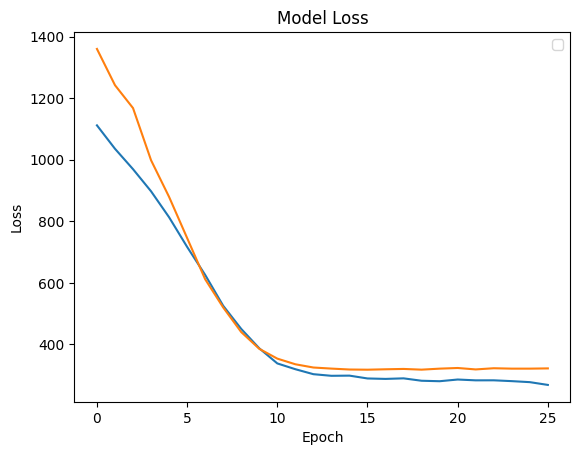

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 324.8459 - mae: 14.3970 - mse: 323.5468 - qwk: 0.4129
Validation loss: 317.8392, Validation MAE: 14.3102


In [38]:
# Graph most recent model history
'''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v)
print(f"Validation loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
'''

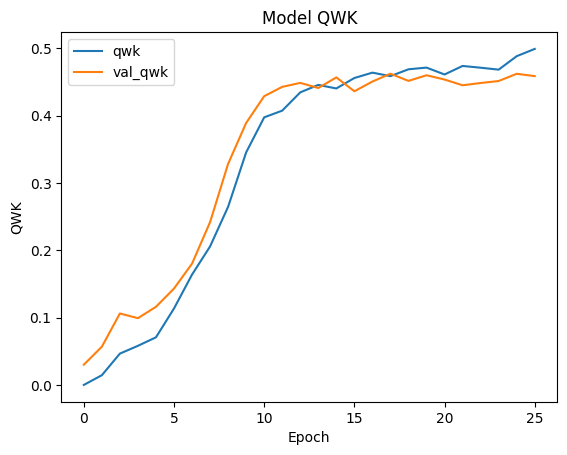

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 324.8459 - mae: 14.3970 - mse: 323.5468 - qwk: 0.4129
Validation QWK: 0.4269


In [39]:
'''
plt.plot(history.history['qwk'])
plt.plot(history.history['val_qwk'])
plt.title('Model QWK')
plt.xlabel('Epoch')
plt.ylabel('QWK')
plt.legend(['qwk','val_qwk'])
plt.show()

val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v)
print(f"Validation QWK: {val_qwk:.4f}")
'''

In [40]:
#model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 128)                 │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,765 (194.40 KB)

 Trainable params: 16,417 (64.13 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 32,836 (128.27 KB)

We have way too many parameters considering we only have 2700 rows of data.

If rule of thumb is we need 10x as much data as params...

We can try a much smaller DNN, as well as augment the data. Or do PCA to have fewer neurons in the input layer.

I am willing to augment the data once or twice (duplicating with noise). More than 
that and I think the risk of overfitting to the training data is too high, even with 
the added noise in the augmentation.

If we augment once, there are ~5400 rows. If we augment twice, there are ~8100 rows.

So we are actually looking for a DNN with only 500-900 trainable params?

# Augment data

In [24]:
# Get standard deviations of each column in X and y
std_X = np.std(X_train_labelled, axis=0)
std_y = np.std(y_train_labelled, axis=0)

In [25]:
X_train_labelled.shape, y_train_labelled.shape

((2736, 34), (2736,))

In [26]:
# Create augmented datasets

X_noise_multiplier=0.1
y_noise_multiplier=0.1

# Not doing this in a for loop because we will not augment more than twice
# And we may choose to add different noisiness to each augmentation
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))
X_train_labelled_noisy.shape, y_train_labelled_noisy.shape

((2736, 34), (2736,))

In [27]:
X_train_labelled_aug1 = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1 = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
X_train_labelled_aug1.shape, y_train_labelled_aug1.shape

((5472, 34), (5472,))

# V3: Smaller model and data augmented once

In [57]:
def create_model_v3():
    model = keras.models.Sequential([
        keras.layers.Dense(20, input_shape=(X_train_labelled.shape[1],), activation="selu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(20, activation="selu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(1, activation="linear")
    ])

    model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mae','mse',qwk],run_eagerly=True) #run_eagerly=True is necessary in order for the tf.numpy() function in qwk to work
    return model

In [58]:
model = create_model_v3()
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                     │ (None, 20)                  │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,141 (4.46 KB)

 Trainable params: 1,141 (4.46 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
'''
# Prepare to store results
validation_qwk = []
validation_losses = []
models = []

# Loop over each fold
for train_index, val_index in kf.split(X_train_labelled_aug1):
    # Split the data into training and validation sets for the current fold
    X_train_t, X_train_v = X_train_labelled_aug1.loc[train_index], X_train_labelled_aug1.loc[val_index]
    y_train_t, y_train_v = y_train_labelled_aug1.loc[train_index], y_train_labelled_aug1.loc[val_index]
    
    # Build a new model for each fold
    model = create_model_v3()
    
    # Define early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model on the training set and evaluate on the validation set
    history = model.fit(
        X_train_t, y_train_t,
        validation_data=(X_train_v, y_train_v),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=2
    )
    
    # Evaluate the model on the validation set
    val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    #val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    validation_qwk.append(val_qwk)
    validation_losses.append(val_loss)
    models.append(model)

# Calculate the average validation loss across all folds
avg_val_qwk = np.mean(validation_qwk)
avg_val_loss = np.mean(validation_losses)
print(f"Average Validation QWK: {avg_val_qwk}, Average Validation Loss: {avg_val_loss}")
'''

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 4s - 65ms/step - loss: 898.3621 - mae: 23.8596 - mse: 898.3621 - qwk: 0.0740 - val_loss: 526.4337 - val_mae: 18.1952 - val_mse: 526.4337 - val_qwk: 0.2203
Epoch 2/100
57/57 - 4s - 65ms/step - loss: 477.4351 - mae: 17.2207 - mse: 477.4351 - qwk: 0.2459 - val_loss: 346.6423 - val_mae: 14.9520 - val_mse: 346.6423 - val_qwk: 0.3752
Epoch 3/100
57/57 - 4s - 65ms/step - loss: 385.7579 - mae: 15.5516 - mse: 385.7579 - qwk: 0.3329 - val_loss: 319.2467 - val_mae: 14.3667 - val_mse: 319.2467 - val_qwk: 0.3778
Epoch 4/100
57/57 - 4s - 63ms/step - loss: 350.6621 - mae: 14.8094 - mse: 350.6621 - qwk: 0.3676 - val_loss: 312.0309 - val_mae: 14.2030 - val_mse: 312.0309 - val_qwk: 0.3960
Epoch 5/100
57/57 - 4s - 63ms/step - loss: 333.0366 - mae: 14.4139 - mse: 333.0366 - qwk: 0.3903 - val_loss: 307.3542 - val_mae: 14.1465 - val_mse: 307.3542 - val_qwk: 0.4017
Epoch 6/100
57/57 - 4s - 64ms/step - loss: 331.7460 - mae: 14.3608 - mse: 331.7460 - qwk: 0.3837 - val_loss: 310.3259 - val_mae: 14.1446 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 4s - 70ms/step - loss: 889.8527 - mae: 23.7747 - mse: 889.8527 - qwk: 0.1030 - val_loss: 547.2053 - val_mae: 18.5421 - val_mse: 547.2053 - val_qwk: 0.1441
Epoch 2/100
57/57 - 4s - 69ms/step - loss: 481.1210 - mae: 17.3578 - mse: 481.1210 - qwk: 0.2443 - val_loss: 332.5453 - val_mae: 14.4595 - val_mse: 332.5453 - val_qwk: 0.3981
Epoch 3/100
57/57 - 4s - 67ms/step - loss: 378.9996 - mae: 15.4240 - mse: 378.9996 - qwk: 0.3517 - val_loss: 301.6948 - val_mae: 13.8148 - val_mse: 301.6948 - val_qwk: 0.4135
Epoch 4/100
57/57 - 4s - 67ms/step - loss: 358.5028 - mae: 15.0887 - mse: 358.5028 - qwk: 0.3543 - val_loss: 299.0734 - val_mae: 13.7279 - val_mse: 299.0734 - val_qwk: 0.4327
Epoch 5/100
57/57 - 4s - 67ms/step - loss: 340.5253 - mae: 14.7681 - mse: 340.5253 - qwk: 0.3775 - val_loss: 293.5031 - val_mae: 13.5715 - val_mse: 293.5031 - val_qwk: 0.4373
Epoch 6/100
57/57 - 4s - 64ms/step - loss: 337.3664 - mae: 14.7112 - mse: 337.3664 - qwk: 0.3956 - val_loss: 293.9720 - val_mae: 13.5813 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 4s - 66ms/step - loss: 819.2934 - mae: 22.6132 - mse: 819.2934 - qwk: 0.0754 - val_loss: 480.3055 - val_mae: 17.5422 - val_mse: 480.3055 - val_qwk: 0.1909
Epoch 2/100
57/57 - 4s - 65ms/step - loss: 444.0466 - mae: 16.6560 - mse: 444.0466 - qwk: 0.2728 - val_loss: 344.5447 - val_mae: 14.7211 - val_mse: 344.5447 - val_qwk: 0.3506
Epoch 3/100
57/57 - 4s - 65ms/step - loss: 374.9289 - mae: 15.4759 - mse: 374.9289 - qwk: 0.3493 - val_loss: 317.2442 - val_mae: 14.0974 - val_mse: 317.2442 - val_qwk: 0.3768
Epoch 4/100
57/57 - 4s - 65ms/step - loss: 349.8003 - mae: 14.8364 - mse: 349.8003 - qwk: 0.3722 - val_loss: 306.7350 - val_mae: 13.9245 - val_mse: 306.7350 - val_qwk: 0.4009
Epoch 5/100
57/57 - 4s - 66ms/step - loss: 342.9285 - mae: 14.6479 - mse: 342.9285 - qwk: 0.3815 - val_loss: 304.2454 - val_mae: 13.8700 - val_mse: 304.2454 - val_qwk: 0.3987
Epoch 6/100
57/57 - 4s - 66ms/step - loss: 334.2870 - mae: 14.5462 - mse: 334.2870 - qwk: 0.3848 - val_loss: 302.8159 - val_mae: 13.8422 

**Score: 0.386, 0.366**

**Thoughts**:
* Small improvement on V1 basic model
* The way we augmented the data was maybe weird, augmenting before splitting into train and val. Perhaps we should split first and then augment the train set only, i.e., write an augment function to use in the cv loop
* We still technically had <10x the number of rows as params. So we can consider augmenting again, or doing PCA

# V4: Using augmentation function

In [31]:
def aug_data(X_train, y_train, noise_factor_X, noise_factor_y):
    std_X = np.std(X_train, axis=0)
    std_y = np.std(y_train, axis=0)
    X_train_noisy = X_train + (noise_factor_X * np.random.normal(0, std_X, X_train.shape))
    y_train_noisy = y_train + (noise_factor_y * np.random.normal(0, std_y, y_train.shape))
    X_train_aug = pd.concat([X_train,X_train_noisy], ignore_index=True)
    y_train_aug = pd.concat([y_train,y_train_noisy], ignore_index=True)
    return (X_train_aug, y_train_aug)



In [29]:
def create_model_v4():
    model = keras.models.Sequential([
        keras.layers.Dense(20, input_shape=(X_train_labelled.shape[1],), activation="selu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(20, activation="selu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(1, activation="linear")
    ])

    model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mae','mse',qwk],run_eagerly=True) #run_eagerly=True is necessary in order for the tf.numpy() function in qwk to work
    return model

In [30]:
model = create_model_v4()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,141 (4.46 KB)

 Trainable params: 1,141 (4.46 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
'''
# Prepare to store results
validation_qwk = []
validation_losses = []
models = []

# Loop over each fold
for train_index, val_index in kf.split(X_train_labelled):
    # Split the data into training and validation sets for the current fold
    X_train_t, X_train_v = X_train_labelled.loc[train_index], X_train_labelled.loc[val_index]
    y_train_t, y_train_v = y_train_labelled.loc[train_index], y_train_labelled.loc[val_index]

    print(X_train_t.shape, y_train_t.shape, X_train_v.shape, y_train_v.shape)
    X_train_t, y_train_t = aug_data(X_train_t, y_train_t, 0.1, 0.1)
    print(X_train_t.shape, y_train_t.shape, X_train_v.shape, y_train_v.shape)    
    
    # Build a new model for each fold
    model = create_model_v4()
    
    # Define early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model on the training set and evaluate on the validation set
    history = model.fit(
        X_train_t, y_train_t,
        validation_data=(X_train_v, y_train_v),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=2
    )
    
    # Evaluate the model on the validation set
    val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    #val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    validation_qwk.append(val_qwk)
    validation_losses.append(val_loss)
    models.append(model)

# Calculate the average validation loss across all folds
avg_val_qwk = np.mean(validation_qwk)
avg_val_loss = np.mean(validation_losses)
print(f"Average Validation QWK: {avg_val_qwk}, Average Validation Loss: {avg_val_loss}")
'''

(1824, 34) (1824,) (912, 34) (912,)
(3648, 34) (3648,) (912, 34) (912,)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 5s - 91ms/step - loss: 875.7547 - mae: 23.7453 - mse: 875.7547 - qwk: 0.0610 - val_loss: 465.3753 - val_mae: 16.9110 - val_mse: 465.3753 - val_qwk: 0.2709
Epoch 2/100
57/57 - 4s - 67ms/step - loss: 438.3978 - mae: 16.5049 - mse: 438.3978 - qwk: 0.2541 - val_loss: 333.6129 - val_mae: 14.6263 - val_mse: 333.6129 - val_qwk: 0.3566
Epoch 3/100
57/57 - 4s - 63ms/step - loss: 355.6319 - mae: 14.9176 - mse: 355.6319 - qwk: 0.3361 - val_loss: 322.2124 - val_mae: 14.4199 - val_mse: 322.2124 - val_qwk: 0.3947
Epoch 4/100
57/57 - 4s - 63ms/step - loss: 323.6082 - mae: 14.3479 - mse: 323.6082 - qwk: 0.3798 - val_loss: 316.6915 - val_mae: 14.3302 - val_mse: 316.6915 - val_qwk: 0.4011
Epoch 5/100
57/57 - 4s - 64ms/step - loss: 320.1348 - mae: 14.1951 - mse: 320.1348 - qwk: 0.3803 - val_loss: 315.9749 - val_mae: 14.3012 - val_mse: 315.9749 - val_qwk: 0.3996
Epoch 6/100
57/57 - 4s - 62ms/step - loss: 311.1091 - mae: 14.0760 - mse: 311.1091 - qwk: 0.4001 - val_loss: 315.2975 - val_mae: 14.2568 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 4s - 64ms/step - loss: 895.6153 - mae: 23.7749 - mse: 895.6153 - qwk: 0.0646 - val_loss: 513.0127 - val_mae: 18.0062 - val_mse: 513.0127 - val_qwk: 0.1641
Epoch 2/100
57/57 - 4s - 64ms/step - loss: 462.5610 - mae: 17.0213 - mse: 462.5610 - qwk: 0.2618 - val_loss: 304.9149 - val_mae: 13.8764 - val_mse: 304.9149 - val_qwk: 0.3893
Epoch 3/100
57/57 - 4s - 65ms/step - loss: 365.8646 - mae: 15.2522 - mse: 365.8646 - qwk: 0.3613 - val_loss: 281.2878 - val_mae: 13.3819 - val_mse: 281.2878 - val_qwk: 0.4247
Epoch 4/100
57/57 - 4s - 63ms/step - loss: 351.6534 - mae: 15.0265 - mse: 351.6534 - qwk: 0.3771 - val_loss: 281.0340 - val_mae: 13.3591 - val_mse: 281.0340 - val_qwk: 0.4039
Epoch 5/100
57/57 - 4s - 62ms/step - loss: 332.1867 - mae: 14.5845 - mse: 332.1867 - qwk: 0.4113 - val_loss: 279.9257 - val_mae: 13.3035 - val_mse: 279.9257 - val_qwk: 0.4004
Epoch 6/100
57/57 - 4s - 63ms/step - loss: 332.7411 - mae: 14.5762 - mse: 332.7411 - qwk: 0.4036 - val_loss: 276.6351 - val_mae: 13.2790 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 4s - 64ms/step - loss: 710.7382 - mae: 21.1324 - mse: 710.7382 - qwk: 0.1302 - val_loss: 469.7377 - val_mae: 17.2835 - val_mse: 469.7377 - val_qwk: 0.2752
Epoch 2/100
57/57 - 4s - 63ms/step - loss: 420.1433 - mae: 16.1372 - mse: 420.1433 - qwk: 0.3008 - val_loss: 343.6344 - val_mae: 14.8401 - val_mse: 343.6344 - val_qwk: 0.3760
Epoch 3/100
57/57 - 4s - 64ms/step - loss: 355.8070 - mae: 14.9431 - mse: 355.8070 - qwk: 0.3573 - val_loss: 329.2273 - val_mae: 14.5956 - val_mse: 329.2273 - val_qwk: 0.3831
Epoch 4/100
57/57 - 4s - 63ms/step - loss: 336.7700 - mae: 14.5493 - mse: 336.7700 - qwk: 0.3675 - val_loss: 320.1608 - val_mae: 14.3850 - val_mse: 320.1608 - val_qwk: 0.4032
Epoch 5/100
57/57 - 4s - 62ms/step - loss: 311.5491 - mae: 13.9891 - mse: 311.5491 - qwk: 0.4125 - val_loss: 316.6977 - val_mae: 14.2872 - val_mse: 316.6977 - val_qwk: 0.4367
Epoch 6/100
57/57 - 4s - 64ms/step - loss: 309.6068 - mae: 14.0128 - mse: 309.6068 - qwk: 0.4172 - val_loss: 318.7800 - val_mae: 14.2702 

**Score: 0.375, 0.364**

Got worse. Maybe we can go back to augmenting the data before the split

# V5: Applying PCA

In [33]:
pca = PCA(n_components=0.95)

In [34]:
X_train_labelled_pca = pd.DataFrame(pca.fit_transform(X_train_labelled))
X_train_labelled_pca.shape, X_train_labelled.shape

((2736, 18), (2736, 34))

In [35]:
# Just 15 components can explain 90% of the variance of the labelled data? 18:95%
X_test_fimpute_pca = pd.DataFrame(pca.transform(X_test_fimpute))
X_test_fimpute_pca.shape, X_test_fimpute.shape

((20, 18), (20, 34))

In [68]:
def create_model_v5():
    model = keras.models.Sequential([
        keras.layers.Dense(24, input_shape=(X_train_labelled_pca.shape[1],), activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(12, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(1, activation="linear")
    ])

    model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mae','mse',qwk],run_eagerly=True) #run_eagerly=True is necessary in order for the tf.numpy() function in qwk to work
    return model

In [69]:
model = create_model_v5()
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                     │ (None, 24)                  │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
X_train_labelled_pca_aug, y_train_labelled_aug = aug_data(X_train_labelled_pca, y_train_labelled, 0.1, 0.1)
X_train_labelled_pca_aug.shape, y_train_labelled_aug.shape

((5472, 18), (5472,))

In [1]:
'''
# Prepare to store results
validation_qwk = []
validation_losses = []
models = []

# Loop over each fold
for train_index, val_index in kf.split(X_train_labelled_pca_aug):    
    # Split the data into training and validation sets for the current fold
    X_train_t, X_train_v = X_train_labelled_pca_aug.loc[train_index], X_train_labelled_pca_aug.loc[val_index]
    y_train_t, y_train_v = y_train_labelled_aug.loc[train_index], y_train_labelled_aug.loc[val_index]

    #print(X_train_t.shape, y_train_t.shape, X_train_v.shape, y_train_v.shape)
    #X_train_t, y_train_t = aug_data(X_train_t, y_train_t, 0.1, 0.1)
    #print(X_train_t.shape, y_train_t.shape, X_train_v.shape, y_train_v.shape)    
    
    # Build a new model for each fold
    model = create_model_v5()
    
    # Define early stopping to avoid overfitting
    #early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    early_stopping = EarlyStopping(monitor='val_qwk', mode='max', patience=20, restore_best_weights=True)

    
    # Train the model on the training set and evaluate on the validation set
    history = model.fit(
        X_train_t, y_train_t,
        validation_data=(X_train_v, y_train_v),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=2
    )
    
    # Evaluate the model on the validation set
    val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    #val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    validation_qwk.append(val_qwk)
    validation_losses.append(val_loss)
    models.append(model)

# Calculate the average validation loss across all folds
avg_val_qwk = np.mean(validation_qwk)
avg_val_loss = np.mean(validation_losses)
print(f"Average Validation QWK: {avg_val_qwk}, Average Validation Loss: {avg_val_loss}")
'''


NameError: name 'kf' is not defined

**Score:**
* early stopping with val_loss: **0.305, 0.348**
* early stopping with val_qwk: **0.308, 0.342**

Thoughts:
* Given small data, we tried augmenting once and used a smaller model to avoid overfitting. Probably 2 or max 3 hidden layers only
* We tried PCA to allow for more neurons in our model without leading to too many params. In theory, I believe in PCA because 90% of variance was explained with just 15 features, and 95% with 18. So we should probably reduce from 34 since we can.
* We tried varying earlystopping monitor to be val_qwk rather than val_loss
* We may still try:
    * Augmenting twice
    * Different model architectures
    * Different regularisation parameters: L1, L2, dropout
    * Changing loss function to be more reflective of qwk
    * Adding sample weights based on number of imputed features
    * Including actigraph data
    * Targeting sii instead of PCIAT-PCIAT_Total

The result of this version was so much worse, that for the next version we'll go back to the V3 architecture, data augmented once, no PCA, early stopping monitor val_loss, and we'll just carefully change one thing at a time

# V6

In [75]:
# Custom loss that combines MSE and QWK
def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error
    #qwk_loss = tf.py_function(quadratic_weighted_kappa, [y_true, y_pred], tf.float64)  # QWK
    qwk_loss = qwk(y_true, y_pred)
    qwk_loss = tf.convert_to_tensor(qwk_loss, dtype=tf.float32)
    # Add a weighting factor
    #return mse_loss
    #return (mse_loss, 10 * qwk_loss)
    return mse_loss - (50 * qwk_loss) + 100 # Subtract qwk loss as higher qwk is better. Multiplier needs to be chosen by trial and error. Added constant so loss is > 0
    #return (-1)*qwk_loss # Didn't work (no gradients provided) - seems it needs to be combined with nmse

In [76]:
a = tf.constant([9.0,54.0,72.0])
b = tf.constant([6.0,61.0,71.0])
c = tf.constant([6.0,61.0,65.0])

print(combined_loss(a,b), combined_loss(a,c))
#combined_loss(a,c)

tf.Tensor(70.57575, shape=(), dtype=float32) tf.Tensor(87.66667, shape=(), dtype=float32)


In [82]:

def create_model_v6():
    model = keras.models.Sequential([
        keras.layers.Dense(20, input_shape=(X_train_labelled.shape[1],), activation="leaky_relu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(20, activation="leaky_relu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(1, activation="linear")
    ])

    #model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=['mae','mse',qwk],run_eagerly=True) #run_eagerly=True is necessary in order for the tf.numpy() function in qwk to work
    model.compile(optimizer=Adam(learning_rate=0.005), loss=combined_loss, metrics=['mae','mse',qwk],run_eagerly=True) #run_eagerly=True is necessary in order for the tf.numpy() function in qwk to work
    return model


In [83]:
model = create_model_v6()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                     │ (None, 20)                  │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,141 (4.46 KB)

 Trainable params: 1,141 (4.46 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
X_train_labelled_aug, y_train_labelled_aug = aug_data(X_train_labelled, y_train_labelled, 0.1, 0.1)
X_train_labelled_aug.shape, y_train_labelled_aug.shape

((5472, 34), (5472,))

In [85]:

# Prepare to store results
validation_qwk = []
validation_losses = []
models = []

# Loop over each fold
for train_index, val_index in kf.split(X_train_labelled_aug):    
    # Split the data into training and validation sets for the current fold
    X_train_t, X_train_v = X_train_labelled_aug.loc[train_index], X_train_labelled_aug.loc[val_index]
    y_train_t, y_train_v = y_train_labelled_aug.loc[train_index], y_train_labelled_aug.loc[val_index]

    #print(X_train_t.shape, y_train_t.shape, X_train_v.shape, y_train_v.shape)
    #X_train_t, y_train_t = aug_data(X_train_t, y_train_t, 0.1, 0.1)
    #print(X_train_t.shape, y_train_t.shape, X_train_v.shape, y_train_v.shape)    
    
    # Build a new model for each fold
    model = create_model_v6()
    
    # Define early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    #early_stopping = EarlyStopping(monitor='val_qwk', mode='max', patience=20, restore_best_weights=True)

    
    # Train the model on the training set and evaluate on the validation set
    history = model.fit(
        X_train_t, y_train_t,
        validation_data=(X_train_v, y_train_v),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=2
    )
    
    # Evaluate the model on the validation set
    val_loss, val_mae, val_mse, val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    #val_qwk = model.evaluate(X_train_v, y_train_v, verbose=2)
    validation_qwk.append(val_qwk)
    validation_losses.append(val_loss)
    models.append(model)

# Calculate the average validation loss across all folds
avg_val_qwk = np.mean(validation_qwk)
avg_val_loss = np.mean(validation_losses)
print(f"Average Validation QWK: {avg_val_qwk}, Average Validation Loss: {avg_val_loss}")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 4s - 68ms/step - loss: 742.1578 - mae: 21.4545 - mse: 742.1578 - qwk: 0.0732 - val_loss: 441.1319 - val_mae: 16.8392 - val_mse: 441.1319 - val_qwk: 0.2165
Epoch 2/100
57/57 - 4s - 70ms/step - loss: 424.8094 - mae: 16.3014 - mse: 424.8094 - qwk: 0.2881 - val_loss: 352.0262 - val_mae: 14.9994 - val_mse: 352.0262 - val_qwk: 0.3675
Epoch 3/100
57/57 - 4s - 68ms/step - loss: 377.4055 - mae: 15.3486 - mse: 377.4055 - qwk: 0.3442 - val_loss: 336.1398 - val_mae: 14.7052 - val_mse: 336.1398 - val_qwk: 0.3628
Epoch 4/100
57/57 - 4s - 67ms/step - loss: 352.4036 - mae: 14.8379 - mse: 352.4036 - qwk: 0.3782 - val_loss: 324.8921 - val_mae: 14.5009 - val_mse: 324.8921 - val_qwk: 0.3894
Epoch 5/100
57/57 - 4s - 71ms/step - loss: 348.9647 - mae: 14.7912 - mse: 348.9647 - qwk: 0.3735 - val_loss: 319.3646 - val_mae: 14.4489 - val_mse: 319.3646 - val_qwk: 0.3938
Epoch 6/100
57/57 - 4s - 70ms/step - loss: 348.1029 - mae: 14.7029 - mse: 348.1029 - qwk: 0.3682 - val_loss: 318.3204 - val_mae: 14.4134 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 5s - 80ms/step - loss: 764.6979 - mae: 21.7991 - mse: 764.6979 - qwk: 0.0993 - val_loss: 445.2636 - val_mae: 16.8562 - val_mse: 445.2636 - val_qwk: 0.1891
Epoch 2/100
57/57 - 4s - 69ms/step - loss: 444.0386 - mae: 16.7292 - mse: 444.0386 - qwk: 0.2788 - val_loss: 343.4548 - val_mae: 14.7467 - val_mse: 343.4548 - val_qwk: 0.3397
Epoch 3/100
57/57 - 4s - 70ms/step - loss: 388.6115 - mae: 15.5764 - mse: 388.6115 - qwk: 0.3413 - val_loss: 324.8168 - val_mae: 14.3099 - val_mse: 324.8168 - val_qwk: 0.3896
Epoch 4/100
57/57 - 4s - 69ms/step - loss: 374.2978 - mae: 15.3408 - mse: 374.2978 - qwk: 0.3492 - val_loss: 315.3692 - val_mae: 14.0786 - val_mse: 315.3692 - val_qwk: 0.4065
Epoch 5/100
57/57 - 4s - 68ms/step - loss: 360.6389 - mae: 15.1819 - mse: 360.6389 - qwk: 0.3634 - val_loss: 311.0690 - val_mae: 13.9706 - val_mse: 311.0690 - val_qwk: 0.4291
Epoch 6/100
57/57 - 4s - 66ms/step - loss: 350.0741 - mae: 14.8894 - mse: 350.0741 - qwk: 0.3815 - val_loss: 302.9891 - val_mae: 13.7934 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 - 4s - 67ms/step - loss: 901.9189 - mae: 23.7681 - mse: 901.9189 - qwk: 0.0796 - val_loss: 533.9165 - val_mae: 18.3367 - val_mse: 533.9165 - val_qwk: 0.2087
Epoch 2/100
57/57 - 4s - 64ms/step - loss: 468.0681 - mae: 16.9938 - mse: 468.0681 - qwk: 0.2666 - val_loss: 370.1227 - val_mae: 15.3357 - val_mse: 370.1227 - val_qwk: 0.3395
Epoch 3/100
57/57 - 4s - 64ms/step - loss: 393.3516 - mae: 15.6580 - mse: 393.3516 - qwk: 0.3295 - val_loss: 337.5006 - val_mae: 14.6910 - val_mse: 337.5006 - val_qwk: 0.3842
Epoch 4/100
57/57 - 4s - 66ms/step - loss: 371.0048 - mae: 15.2757 - mse: 371.0048 - qwk: 0.3437 - val_loss: 328.1068 - val_mae: 14.4059 - val_mse: 328.1068 - val_qwk: 0.3910
Epoch 5/100
57/57 - 4s - 64ms/step - loss: 349.5600 - mae: 14.8324 - mse: 349.5600 - qwk: 0.3812 - val_loss: 319.8004 - val_mae: 14.2388 - val_mse: 319.8004 - val_qwk: 0.3853
Epoch 6/100
57/57 - 4s - 64ms/step - loss: 347.7215 - mae: 14.8240 - mse: 347.7215 - qwk: 0.3750 - val_loss: 314.5203 - val_mae: 14.1270 

# Final prediction with model

In [86]:
y_test = test_data[['id']]

In [88]:
y_test['PCIAT-PCIAT_Total_dnn'] = np.mean([model.predict(X_test_fimpute) for model in models], axis=0)
#y_test['PCIAT-PCIAT_Total_dnn'] = np.mean([model.predict(X_test_fimpute_pca) for model in models], axis=0)
#y_test['PCIAT-PCIAT_Total_dnn'] = model.predict(X_test_fimpute)
y_test.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-88-56e40812541d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['PCIAT-PCIAT_Total_dnn'] = np.mean([model.predict(X_test_fimpute) for model in models], axis=0)


,id,PCIAT-PCIAT_Total_dnn
0,00008ff9,28.629999
1,000fd460,14.883449
2,00105258,31.581049
3,00115b9f,23.590620
4,0016bb22,39.803635


In [89]:
y_test['PCIAT-PCIAT_Total'] = y_test.apply(
    lambda row: (row['PCIAT-PCIAT_Total_dnn']),
axis=1)

y_test['sii'] = y_test.apply(lambda row: 0 if row['PCIAT-PCIAT_Total']<=30 else 
                             (1 if row['PCIAT-PCIAT_Total']<50 else (
                                2 if row['PCIAT-PCIAT_Total']<80 else (3)
                            )), axis=1)

y_test.head()

<ipython-input-89-9d1fb4b2c713>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['PCIAT-PCIAT_Total'] = y_test.apply(
<ipython-input-89-9d1fb4b2c713>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['sii'] = y_test.apply(lambda row: 0 if row['PCIAT-PCIAT_Total']<=30 else


,id,PCIAT-PCIAT_Total_dnn,PCIAT-PCIAT_Total,sii
0,00008ff9,28.629999,28.629999,0
1,000fd460,14.883449,14.883449,0
2,00105258,31.581049,31.581049,1
3,00115b9f,23.590620,23.590620,0
4,0016bb22,39.803635,39.803635,1


In [90]:
solution = y_test[['id','sii']]
solution.to_csv("submission.csv", index=False)